#Projeto de Cocada 2024/2
##Tema: Análise de Álbuns Musicais com PCA
####Aluno: Nicholas Valle Gross | 122101661


---





##Objetivo
Esse projeto tem como objetivo analisar o gosto musical dos usuários e recomendar álbuns de música que sejam compatíveis com suas preferências, fazendo uso da Análise de Componentes Principais (PCA).  \
Por meio do PCA, seremos capazes de simplificar e visualizar dados complexos em um espaço de menor dimensão, para então conseguirmos identificar padrões nos dados e categorizar os álbuns de maneira eficiente. \
Ao longo do projeto, será usada a biblioteca sklearn do python, que dispõe de várias ferramentas de machine learning e análise de dados.





##Dataset
O Dataset que será usado nesse projeto vem de um site chamado Rate Your Music, que é usado para catalogar, avaliar e criticar artistas e álbuns musicais, além de ser uma plataforma para descobrir e divulgar bandas e artistas. Nele podemos encontrar informações como data de lançamento, nota média dos usuários, críticas sobre o álbum, gêneros primários e secundários, descrições do álbum, etc.\
Vamos usar o Pandas para conseguir importar e manipular o dataset.

\
O dataset foi provido por um usuário do Kaggle, que converteu todas as informações dos 5000 álbuns mais avaliados do site, até 11/2022, para um arquivo csv. O link para o dataset está no final do documento.


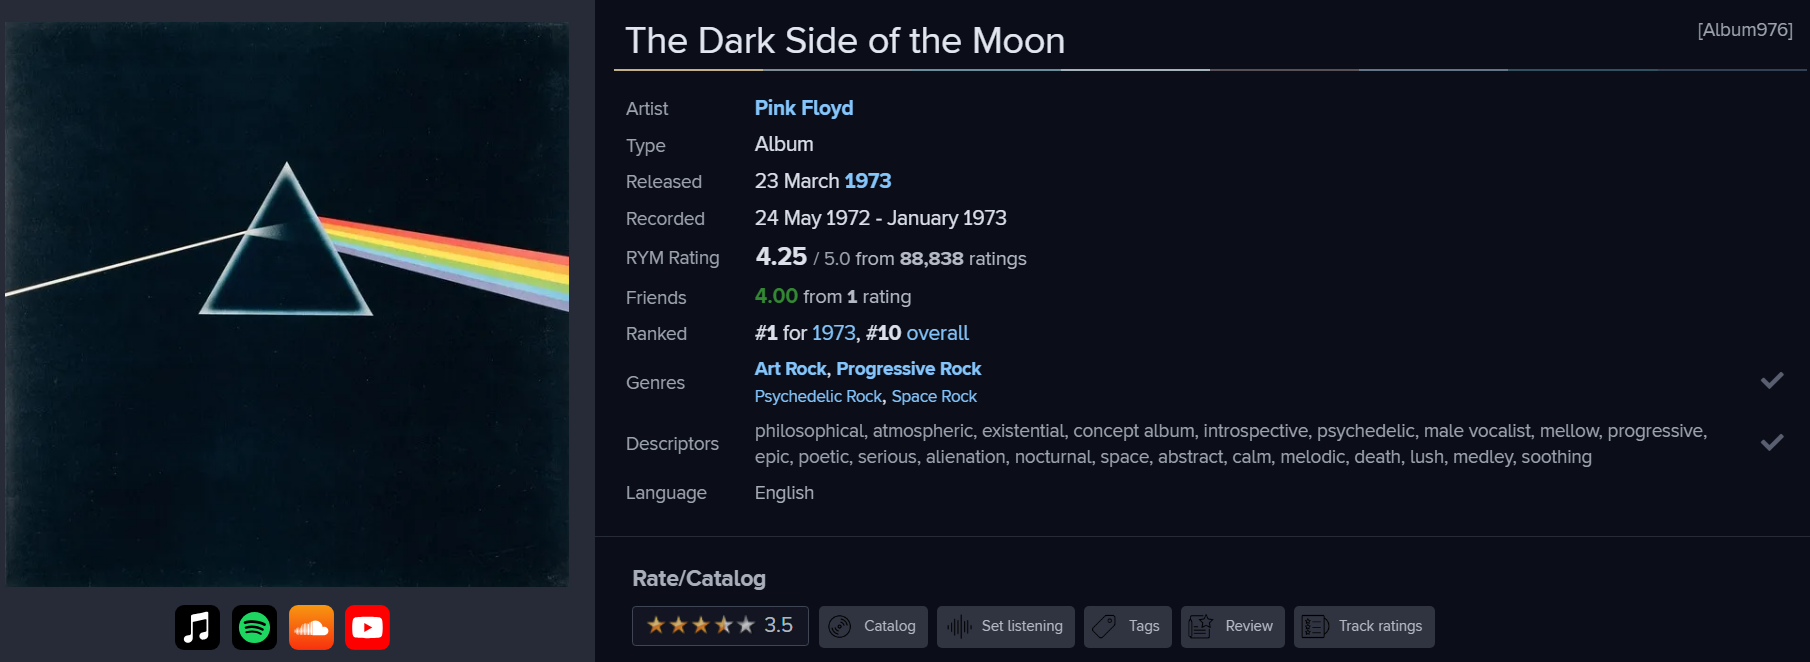

In [3]:
#importando todas as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import math

#Parte 1

##Filtragem e rotulagem dos dados

Primeiramente, precisamos filtrar os dados e remover informações desnecessários para o nosso problema. Inicialmente, o dataset tem essa cara aqui:

In [4]:
albuns = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projeto_de_Cocada/rym_clean1.csv")
albuns.head()

,Unnamed: 0,position,release_name,artist_name,release_date,release_type,primary_genres,secondary_genres,descriptors,avg_rating,rating_count,review_count
0,1,1,OK Computer,Radiohead,1997-06-16,album,"Alternative Rock, Art Rock",NaN,"melancholic, anxious, futuristic, malevocals, ...",4.24,74027,1541
1,2,2,Kid A,Radiohead,2000-10-03,album,"Art Rock, Experimental Rock, Electronic","Ambient, Electronic, IDM","cold, melancholic, futuristic, anxious, atmosp...",4.23,61658,751
2,3,3,The Dark Side of the Moon,Pink Floyd,1973-03-23,album,"Art Rock, Progressive Rock","Psychedelic Rock, Space Rock","philosophical, atmospheric, introspective, exi...",4.21,60192,1557
3,4,4,Loveless,My Bloody Valentine,1991-11-11,album,"Shoegaze, Noise Pop","Dream Pop, Neo-Psychedelia","noisy, ethereal, atmospheric, romantic, love, ...",4.24,53174,1264
4,5,5,My Beautiful Dark Twisted Fantasy,Kanye West,2010-11-22,album,"Pop Rap, Hip Hop",Art Pop,"epic, boastful, passionate, sampling, hedonist...",4.09,52149,638


Para o intuito da nossa aplicação, as únicas informações importantes do dataset são o nome do álbum, nome do artista, generos primários e secundários, que é o que de fato usaremos para classificar os dados. Todo o resto é irrelevante.\
\
Segue abaixo a tabela simplificada:

In [5]:
albuns.drop(["Unnamed: 0", "position", "release_date", "release_type", "review_count", "descriptors", "avg_rating", "rating_count"], axis="columns", inplace=True)
albuns.head()

,release_name,artist_name,primary_genres,secondary_genres
0,OK Computer,Radiohead,"Alternative Rock, Art Rock",NaN
1,Kid A,Radiohead,"Art Rock, Experimental Rock, Electronic","Ambient, Electronic, IDM"
2,The Dark Side of the Moon,Pink Floyd,"Art Rock, Progressive Rock","Psychedelic Rock, Space Rock"
3,Loveless,My Bloody Valentine,"Shoegaze, Noise Pop","Dream Pop, Neo-Psychedelia"
4,My Beautiful Dark Twisted Fantasy,Kanye West,"Pop Rap, Hip Hop",Art Pop


Em seguida, listamos todos os gêneros musicais presentes no dataset:

In [6]:
generos_primarios = albuns['primary_genres'].dropna().str.split(', ')
generos_secundarios = albuns['secondary_genres'].dropna().str.split(', ')
all_genres = generos_primarios.explode().tolist() + generos_secundarios.explode().tolist()
generos = list(set(all_genres))
generos

['Glitch',
 'Big Band',
 'Electro-Industrial',
 'New Romantic',
 'Sketch Comedy',
 'Kayōkyoku',
 'Art Pop',
 'Flamenco',
 'Epic Music',
 'Ambient,2-Step',
 'Yacht Rock',
 'Danzón',
 'Neo-Psychedelia',
 'Inuit Vocal Games',
 'Alternative Metal',
 'Carols',
 'Europop',
 'Dub',
 'Valscriollo',
 'Nyahbinghi',
 'Future Funk',
 'Saeta',
 'Contemporary R&B',
 'Death Industrial',
 'Neo-Soul',
 'Grindcore',
 'Bebop',
 'Freak Folk',
 'Christmas Music',
 'Modal Jazz',
 'Future Bass',
 'Indie Pop',
 'Ambient Techno',
 'Chamber Music',
 'Chillwave',
 'Latin Electronic',
 'Conscious Hip Hop',
 'Jingles',
 'Aggrotech',
 'Delta Blues',
 'Sequencer & Tracker',
 'Glitch Hop',
 'Neoclassical Metal',
 'Liquid Drumand Bass',
 'Wonky',
 'Tuvan Throat Singing',
 'Post-Metal',
 'Comedy Rock',
 'New Orleans R&B',
 'Melodic Black Metal',
 'Jump Blues',
 'Flamenco Pop',
 'Psychedelic Soul',
 'EBM',
 'Footwork Jungle',
 'Stoner Metal',
 'Hyphy',
 'Neo-Prog',
 'Noise',
 'Brazilian Music',
 'Tejano',
 'Dub Techno',

In [7]:
num_generos = len(generos)
num_generos

743

Como podemos ver, temos bastantes gêneros, então, de inicio, vamos simplificar o dataset e funilar os gêneros musicais para apenas 3: Rock/Metal, Rap/Hip-Hop e Pop.\
Para isso, vamos criar uma função para rotular os álbuns de acordo com o gênero. Caso o gênero esteja na coluna de gêneros primários do álbum, será atribuido 1 para aquele gênero, caso esteja na de gêneros secundários, será atribuido 0.5. E esses valores vamos guardar em um outro dataframe do Pandas.\
Para fim de generalização, gêneros que tenham 'Rock' ou 'Metal' no nome serão rotulados como 'Rock/Metal', os que tiverem 'Rap' ou 'Hip Hop' serão rotulados como 'Rap/Hip-Hop', e 'Pop' como 'Pop'.
Inicialmente, como estamos apenas trabalhando com álbuns que pertençam a esse 3 grupos, qualquer álbum que não se enquadre nesse gêneros serão descartados por agora.

In [8]:
def rotular_albuns(albuns):
    albuns_rotulados = pd.DataFrame(columns=['release_name', 'artist_name', 'Rock_Metal', 'Rap_Hip_Hop', 'Pop'])

    for index, album in albuns.iterrows():

        album = albuns.iloc[index]
        rock_metal = 0
        pop = 0
        rap_hip_hop = 0

        if pd.isna(album["primary_genres"]):
            continue

        if "Rock" in album['primary_genres']:
            rock_metal = 1
        if "Metal" in album['primary_genres']:
            rock_metal = 1
        if "Pop" in album['primary_genres']:
            pop = 1
        if "Rap" in album['primary_genres']:
            rap_hip_hop = 1
        if "Hip Hop" in album['primary_genres']:
            rap_hip_hop = 1

        if not pd.isna(album["secondary_genres"]):
            if "Rock" in album['secondary_genres']:
                rock_metal = max(rock_metal, 0.5)  # Peso secundário
            if "Metal" in album['secondary_genres']:
                rock_metal = max(rock_metal, 0.5)
            if "Pop" in album['secondary_genres']:
                pop = max(pop, 0.5)
            if "Rap" in album['secondary_genres']:
                rap_hip_hop = max(rap_hip_hop, 0.5)
            if "Hip Hop" in album['secondary_genres']:
                rap_hip_hop = max(rap_hip_hop, 0.5)

        album['Rock_Metal'] = rock_metal
        album['Pop'] = pop
        album['Rap_Hip_Hop'] = rap_hip_hop

        if rock_metal == 0 and rap_hip_hop == 0 and pop == 0: #Se não pertencer a nenhum dos generos estabelecidos, descarte
            continue

        album.drop(['primary_genres', 'secondary_genres'], errors='ignore', inplace=True)
        albuns_rotulados = pd.concat([albuns_rotulados, album.to_frame().T], axis="index")

    albuns_rotulados.reset_index(drop=True, inplace=True)
    return albuns_rotulados

In [9]:
albuns_rotulados = rotular_albuns(albuns)
albuns_rotulados.head(10)

,release_name,artist_name,Rock_Metal,Rap_Hip_Hop,Pop
0,OK Computer,Radiohead,1,0,0
1,Kid A,Radiohead,1,0,0
2,The Dark Side of the Moon,Pink Floyd,1,0,0
3,Loveless,My Bloody Valentine,0,0,1
4,My Beautiful Dark Twisted Fantasy,Kanye West,0,1,1
5,In Rainbows,Radiohead,1,0,0.5
6,Wish You Were Here,Pink Floyd,1,0,0
7,In the Aeroplane Over the Sea,Neutral Milk Hotel,1,0,0
8,The Bends,Radiohead,1,0,0
9,To Pimp a Butterfly,Kendrick Lamar,0,1,0


Agora vamos transformar essa tabela com os albuns rotulados por gênero em uma matriz contendo apenas os valores respectivos aos gêneros que foram estabelecidos.

In [10]:
album_por_genero = albuns_rotulados.to_numpy()
album_por_genero = np.delete(album_por_genero, [0, 1], 1)
album_por_genero

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0.5, 0, 1]], dtype=object)

In [11]:
def plotar_albuns2d(albuns):
    x = albuns[:, 0]
    y = albuns[:, 1]
    plt.scatter(x, y, color='red')
    plt.title('Aproximação de Posto 2')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()

def plotar_albuns3d(albuns):
    x = albuns[:, 0]
    y = albuns[:, 1]
    z = albuns[:, 2]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c='r', marker='o')
    plt.title('Aproximação de Posto 3')
    ax.set_xlabel('Componente Principal 1')
    ax.set_ylabel('Componente Principal 2')
    ax.set_zlabel('Componente Principal 3')
    plt.show()

Agora podemos projetar os álbuns em 3d, usando a matriz que construímos:

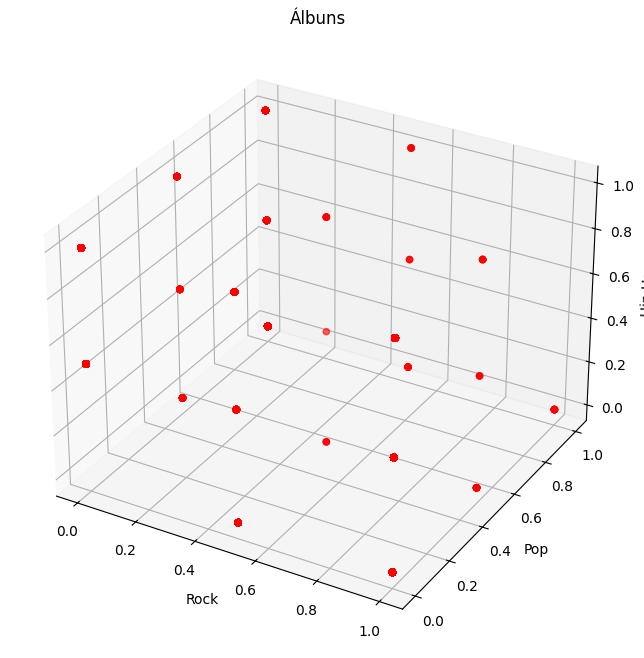

In [12]:
rock = album_por_genero[:, 0]
pop = album_por_genero[:, 1]
hiphop = album_por_genero[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rock, pop, hiphop, color='red', marker='o')
ax.set_title("Álbuns")
ax.set_xlabel('Rock')
ax.set_ylabel('Pop')
ax.set_zlabel('Hip Hop')

plt.show()

##Reduzindo a dimensionalidade com PCA

Nesse próximo passo, vamos usar o PCA para encontar uma aproximação de posto 2 dos álbuns.\
\
Primeiramente, vamos criar alguns usuários e especificar seus gostos musicais. Para isso, criamos uma matriz usuário por gênero, em que cada linha da matriz, a posição 0 será o quanto ele gosta de 'rock/metal', a posição 1 será o quanto ele gosta de 'Rap/Hip Hop', e a 2 o quanto ele gosta de 'Pop'.

In [13]:
usuario_por_genero = np.array([[0.8, 0., 0.2],
                               [0., 0.7, 0.3],
                               [0.6, 0.3, 0.1],
                               [0., 0.1, 0.9]])
usuario_por_genero

array([[0.8, 0. , 0.2],
       [0. , 0.7, 0.3],
       [0.6, 0.3, 0.1],
       [0. , 0.1, 0.9]])

E agora o PCA entra em ação. Vamos calcular a matriz de covariância C. E em seguida vamos calcular os autovetores de C, usando a função fit_transform() da biblioteca sklearn.

In [14]:
A = usuario_por_genero @ album_por_genero.T
C = A @ A.T
pca = PCA(n_components=2)
C_reduzido = pca.fit_transform(C)
C_reduzido

array([[1054.18815409,   28.76092827],
       [-989.2406833 , -244.10676844],
       [ 443.07771638, -170.74773395],
       [-508.02518716,  386.09357413]])

Então, calculamos a projeção dos álbuns nas componente principais que calculamos pelo PCA e plotamos.

In [15]:
pca_album = PCA(n_components=2)
pca_album.fit(album_por_genero)

# Projetar os álbuns nas componentes principais
albuns_projetados = pca_album.transform(album_por_genero)
albuns_projetados

array([[ 0.50088657, -0.08506097],
       [ 0.50088657, -0.08506097],
       [ 0.50088657, -0.08506097],
       ...,
       [ 0.50088657, -0.08506097],
       [ 0.50088657, -0.08506097],
       [-0.43923488,  0.51724751]])

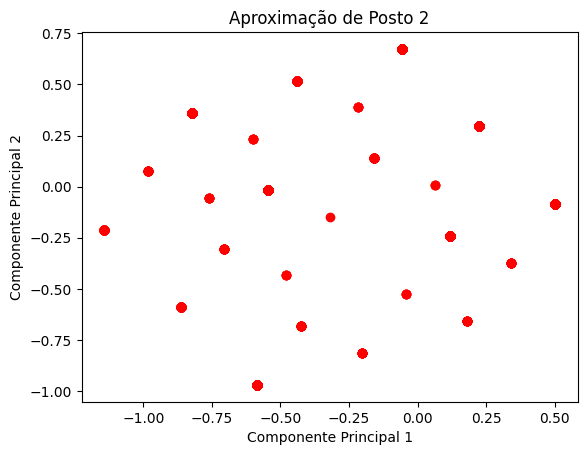

In [16]:
plotar_albuns2d(albuns_projetados)

##Resultados
Como podemos ver, a aproximação de posto 2 dos álbuns ficou muito esparsa e um tanto quanto inconclusiva, já que a nossa modelagem foi muito genérica, fazendo com que muitos álbuns ficassem aglomerados nos mesmos pontos, sendo basicamente inútil para a nossa análise dos dados.\
Conclui-se então, que a nossa escolha de ter usado apenas 3 gêneros não foi muito boa, e não nos permitiu tirar conclusões sobre o dataset. Além de ser muito simplista, a nossa modelagem excluiu parte dos álbuns, por não pertencerem a nenhum dos 3 gêneros. \
Portanto, tendo isso em mente, a solução mais óbvia para o nosso problema se torna usar todos os gêneros presentes no dataset, e trabalhar com o PCA para reduzir a dimensionalidade e assim conseguir visualizar os dados de forma simplificada.


---



#Parte 2

Para pegar todos os gêneros musicais, vamos ter que modificar a função de rotulagem dos álbuns. A nova função executa a mesma lógica da versão antiga(1 para gêneros primários e 0.5 para gêneros secundários), além de ser mais simples. Só que agora, ao invés de 3, a matriz terá 743 colunas, uma para cada gênero do dataset, indicando o pertencimento do álbum àquele gênero.

In [17]:
def rotular_albuns(albuns, generos):
    #o tamanho da matriz será numero de álbuns x numero de generos
    albuns_rotulados = np.zeros([albuns.shape[0], len(generos)])

    for index, album in albuns.iterrows(): #para cada álbum

        album = albuns.iloc[index]

        i=0
        for genero in generos: #para cada genero

            if not isinstance(genero, str): #se o genero não for string(NaN), descarte
                continue

            if isinstance(album['secondary_genres'], str): #se o gênero estiver em gêneros secundários, atribuimos 1
                if genero in album['secondary_genres']:
                    albuns_rotulados[index][i] = 0.5

            if isinstance(album['primary_genres'], str): #se o gênero estiver em gêneros primários, atribuimos 0.5
                if genero in album['primary_genres']:
                    albuns_rotulados[index][i] = 1

        #eu chequei os gêneros secundários primeiro, para não sobscreever os valor do gênero primário
        #caso contrário, isso mudaria a projeção dos álbuns

            i+=1

    return albuns_rotulados

In [18]:
album_por_genero = rotular_albuns(albuns, generos)
album_por_genero

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

Além disso, vamos mudar um pouco como modelamos as preferências dos usuários. Como não é viável perguntar ao usuário o quanto ele gosta de cada um dos 743 gêneros musicais, vamos pedir para que ele nos diga os seus estilos musicais favoritos. Então, vamos criar um vetor, inicialmente nulo, em que o indice dos gêneros favoritos será 1 e todo o resto será 0. Por final, juntaremos todos esses vetores em uma matriz usuario por genero.

In [19]:
def rotular_usuario(generos, generos_preferidos):
    usuario_rotulado = np.zeros(len(generos))
    i=0
    for genero in generos:
        if genero in generos_preferidos:
            usuario_rotulado[i] = 1
        i+=1
    return usuario_rotulado

Criando usuários com suas preferências.

In [20]:
#Criando usuários
u1 = ['Alternative Rock', 'Art Rock', 'Industrial Hip Hop', 'Hardcore Punk']
u2 = ['Jazz Rap', 'Chipmunk Soul', 'Neo-Psychedelia', 'Trip Hop', 'Boom Bap']
u3 = ['Tech House', 'Progressive Electronic', 'EDM', 'Glitch']

#Rotulando os usuários
u1_rotulado = rotular_usuario(generos, u1)
u2_rotulado = rotular_usuario(generos, u2)
u3_rotulado = rotular_usuario(generos, u3)

#Concatenamos as preferencais dos usuarios em uma matriz usuarios_por_generos
usuario_por_genero = np.stack((u1_rotulado, u2_rotulado, u3_rotulado))
usuario_por_genero

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

##PCA

Certo. Agora que temos as nossas matrizes usuário por gênero e álbum por gênero, podemos encontrar a nossa matriz A, usuários por álbum. Então, achamos a matriz de Covariância $C=AA^T$ e aplicamos PCA para encontrar os autovetores de C, que serão as nossas componentes principais. Por fim, faremos a projeção dos álbuns nessas componentes para reduzir dimensionalidade do dataset, e conseguirmos vizualizá-lo de forma mais intuitiva.

In [21]:
A = usuario_por_genero @ album_por_genero.T #matriz usuário por álbum
C = A @ A.T #matriz de covariância
pca = PCA(n_components=3)
C_reduzido = pca.fit_transform(C)
C_reduzido #componentes principais

array([[ 4.54086473e+02,  1.26818414e+01,  1.20916809e-14],
       [-2.48191858e+02,  1.97879935e+02,  1.20916809e-14],
       [-2.05894615e+02, -2.10561776e+02,  1.20916809e-14]])

Calculando as projeções dos álbuns nas componentes principais:

In [22]:
pca_album = PCA(n_components=3)
pca_album.fit(album_por_genero)
albuns_projetados = pca_album.transform(album_por_genero)
albuns_projetados

array([[ 0.71463706, -0.36966227,  0.07654083],
       [ 0.47935007, -0.36964055,  0.17629437],
       [ 0.65663764, -0.44506509,  0.03157139],
       ...,
       [-0.45184223, -0.19320039, -0.30322498],
       [-0.41772791, -0.23443627, -0.27919419],
       [ 0.21291811,  0.73260846,  0.07476557]])

In [23]:
albuns_projetados2d = albuns_projetados[:, 0:2]
albuns_projetados3d = albuns_projetados[:, 0:3]

Plotando os álbuns em 2d:

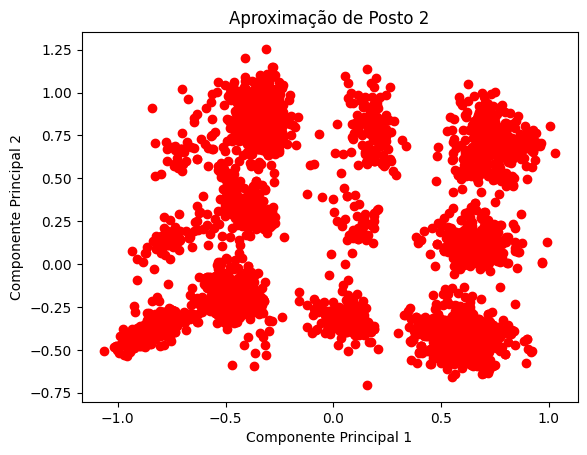

In [24]:
plotar_albuns2d(albuns_projetados2d)

Plotando os álbuns em 3d:

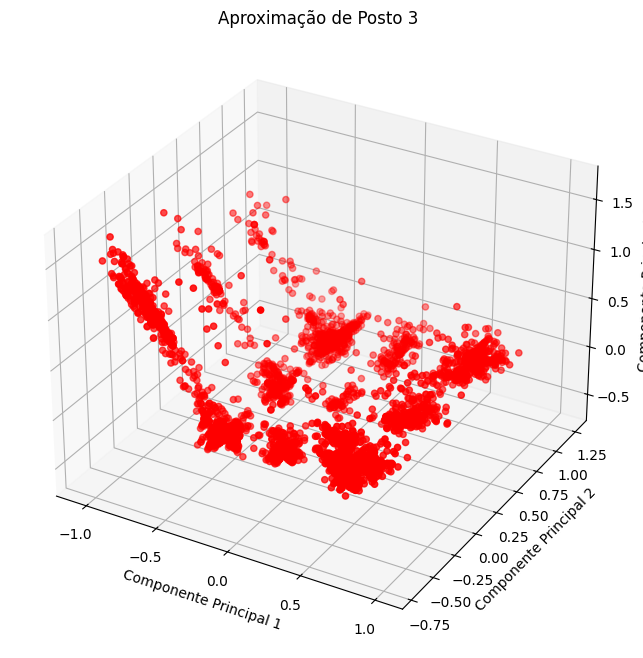

In [25]:
plotar_albuns3d(albuns_projetados3d)

##Resultados
Dessa vez, conseguimos ver nitidamente a formação de 9 clusters bem definidos nos 2 gráficos que geramos. Então, ter usado todos os gêneros musicais de fato nos ajudou a entender melhor o dataset. E o PCA nos ajudou a quebrar a complexidade dos dados, que estavam em dimensão alta, para conseguimos vizualizá-los. Antes, a nossa matriz álbum por gênero era 5000x743, e depois do PCA conseguimos aproximações 5000x3 e até 5000x2.



---





#Parte 3

##Clusterização

Nessa próxima parte, iremos usar o módulo clustering do sklearn, que contém várias funções de clusterização, cada uma para conjuntos de dados diferentes. Na fase de testes, eu usei vários dos algoritmos presentes no módulo, e o que conseguiu fazer a clusterização mais coerente foi o K-means. Ele é um algoritmo de propósito geral e funciona para uma vasta gama de aplicações, se adaptando bem para conjuntos grandes de dados. \
Ele é o clustering que aprendemos em sala, onde, inicialmente, pegamos $k$ pontos aleatórios para serem os centróides de cada um dos $k$ clusters. Então, a cada iteração do algoritmo, atribuimos cada ponto ao cluster de centroide mais próximo, e depois calculamos o ponto médio de cada cluster para ser o novo centróide. Por fim, verificamos a diferença entre o centróide novo e o centróide antigo, e o algoritmo termina quando essa diferença for pequena o suficiente, ou quando os centroides não mudarem.\
O K-means visa minimizar a inércia, que é a soma dos quadrado das distâncias entre os pontos e os centroides dos clusters: \
\
$Inercia = \sum^{k}_{i=1}\sum_{x \in C_k}||x-\mu_k||^2 $ \
\
A inércia pode ser usada para medir a coerência dos clusters, mas tem suas desvantagens:

1. O K-means assume que os clusters são convexos e isotrópicos(distribuição igual para todas as direções), logo, não se adapta bem com clusters muito alongados ou irregulares.
2. O K-means não sabe lidar muito bem com dados em alta dimensão, o que é chamado de maldição de dimensionalidade. Porém, como usamos o PCA para reduzir a dimensionalidade dos dados, isso não será um problema.

\
O algoritmo do K-means exige que o número de clusters seja especificado. Anteriormente, quando projetamos os álbuns nas componentes principais, identificamos 9 clusters. Porém, quando fui testar, 9 clusters não eram o suficientes para fazer uma clusterização coerente, pelo menos em 2d, então tive que aumentar para 10. Além disso, adicionei um parametro 'init='random'', que faz com que a escolha dos centroides iniciais seja aleatória.

In [26]:
clustering = KMeans(n_clusters=10, random_state=0, init='random', n_init="auto").fit(albuns_projetados2d)

O vetor labels indica o cluster de cada ponto. Então pegamos os pontos de cada cluster e colocamos em um dicionário chamado cluster, em que cada entrada tem os pontos de cada cluster.

In [27]:
labels = clustering.labels_

clusters2d = {}
for cluster_id in np.unique(labels):
    clusters2d[cluster_id] = albuns_projetados2d[labels == cluster_id]

clusters2d

{0: array([[0.71337286, 0.774911  ],
        [0.80602115, 0.78930775],
        [0.74974919, 0.76421024],
        [0.78302216, 0.69026348],
        [0.69499912, 0.64600083],
        [0.92422672, 0.56726888],
        [0.73687107, 0.74198494],
        [0.53966898, 0.85717877],
        [0.76083424, 0.53502269],
        [0.67184337, 0.47585357],
        [0.84982254, 0.83209011],
        [0.79663195, 0.8885217 ],
        [0.80297354, 0.53168695],
        [0.78163667, 0.69554041],
        [0.75907485, 0.64228563],
        [0.70394608, 0.70940698],
        [0.72493294, 0.71444464],
        [0.70769927, 0.69712501],
        [0.73977763, 0.66628631],
        [0.62781795, 0.56714087],
        [0.7736077 , 0.69337202],
        [0.67604097, 0.76878127],
        [0.70769927, 0.69712501],
        [0.70717573, 0.7398634 ],
        [0.8285875 , 0.60997513],
        [0.89402819, 0.74568246],
        [0.88927734, 0.69902885],
        [0.67275484, 0.51601978],
        [0.94449974, 0.68965976],
        [0.

In [28]:
cores = ['red', 'blue', 'green', 'orange', 'lime', 'yellow', 'purple', 'navy', 'lightcoral', 'turquoise', 'slategrey', 'black']

In [29]:
def plotar_clusters2d(clusters):
    n_clusters = len(clusters)
    for i in range(n_clusters):
        plt.scatter(clusters[i][:, 0], clusters[i][:, 1], color=cores[i], label=f'Cluster {i+1}')

    plt.title('Clusters em 2D')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()

def plotar_clusters3d(clusters):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for cluster_id, album in clusters.items():
        color = plt.cm.rainbow(float(cluster_id) / clustering.n_clusters)
        ax.scatter(album[:, 0], album[:, 1], album[:, 2], color=cores[cluster_id], label=f'Cluster {cluster_id+1}')

    ax.set_title('Clusters em 3D')
    ax.set_xlabel("Componente Principal 1")
    ax.set_ylabel("Componente Principal 2")
    ax.set_zlabel("Componente Principal 3")
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.show()

Plotando os clusters em 2d

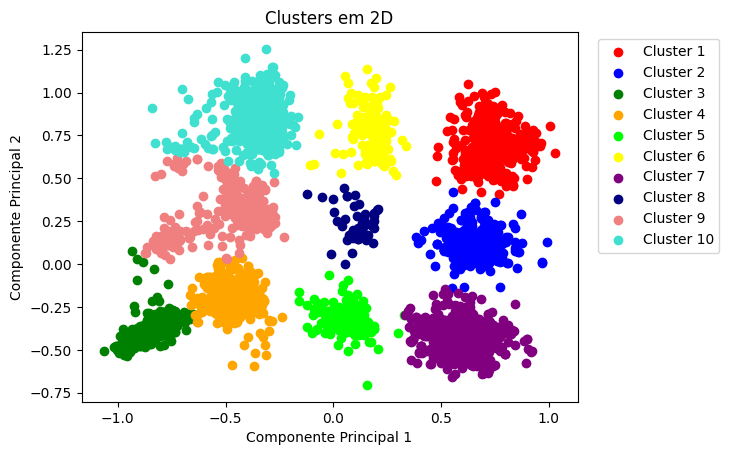

In [30]:
plotar_clusters2d(clusters2d)

Ótimo. Conseguimos uma clusterização consistente, mas tem um detalhe. O problema dessa clusterização é que ela planifica os dados e elimina a tridimensionalidade do dataset, que pode ser valiosa para a nossa análise. Então, ao invés de fazer usar os mesmo cluster para a aproximação de posto 3, vamos aumentar de novo o número de clusters e rodar o kmeans de novo, só que agora com os albuns projetados no 3d. Isso vai garantir que representamos os dados de forma mais fiel ao dataset e consigamos fazer uma análise mais prescisa.

In [31]:
num_clusters = 12
clustering = KMeans(n_clusters=num_clusters, random_state=0, init='random', n_init="auto").fit(albuns_projetados3d)
labels = clustering.labels_

clusters3d = {}
for cluster_id in np.unique(labels):
    clusters3d[cluster_id] = albuns_projetados3d[labels == cluster_id]

clusters3d

{0: array([[ 0.71463706, -0.36966227,  0.07654083],
        [ 0.47935007, -0.36964055,  0.17629437],
        [ 0.65663764, -0.44506509,  0.03157139],
        ...,
        [ 0.42108918, -0.32792642, -0.12278888],
        [ 0.5253966 , -0.48785219, -0.11143287],
        [ 0.5293951 , -0.44189941, -0.04966489]]),
 1: array([[0.71337286, 0.774911  , 0.23381595],
        [0.80602115, 0.78930775, 0.27399886],
        [0.74974919, 0.76421024, 0.2483755 ],
        ...,
        [0.7529755 , 0.52010205, 0.20593315],
        [0.71544133, 0.89473507, 0.20663345],
        [0.76860159, 0.71109667, 0.25285132]]),
 2: array([[ 0.05958168, -0.33073722, -0.16080363],
        [ 0.11331515, -0.29609943,  0.01027335],
        [ 0.09726622, -0.34963975, -0.10969412],
        ...,
        [ 0.06003088, -0.38066531, -0.21107342],
        [ 0.12188731, -0.25117144, -0.12405217],
        [ 0.10329645, -0.2972144 , -0.12843736]]),
 3: array([[-5.19864422e-01,  5.88034661e-01, -2.99226676e-01],
        [-4.327710

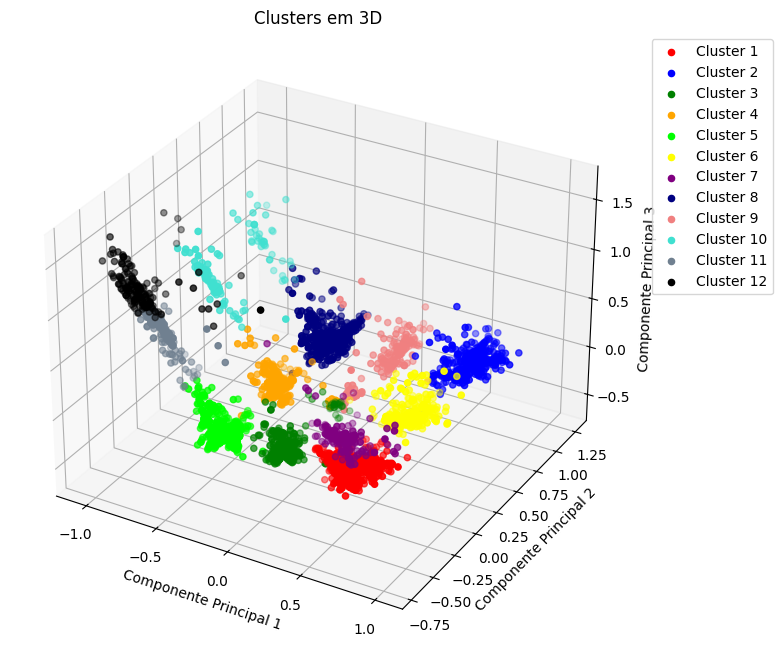

In [32]:
plotar_clusters3d(clusters3d)

##Ánalise dos Clusters e Classificação

Agora que temos os clusters, precisamos analisá-los e tentar achar algum padrão. Para isso, vamos criar uma função para analisar cada cluster e retornar os gêneros que são predominantes naquele cluster.\
Primeiro, criamos uma matriz cluster por genero, que vai indicar a recorrência de cada um dos gêneros por cluster. E como queremos apenas os gêneros predominantes, vamos levar em consideração apenas os gêneros primários dos álbuns. Depois, calculamos as porcentagens de cada gênero no cluster, dividindo o número de recorrências de cada gênero e dividindo pelo total de recorrências. Então, pegamos os 10 gêneros mais recorrentes de cada cluster e colocamos em um dicionário.

In [33]:
def analisar_clusters(album_por_genero, labels):
    num_generos = album_por_genero.shape[1]
    num_clusters = len(np.unique(labels))

    #Calculando cluster por gênero
    cluster_por_genero = np.zeros([num_clusters, num_generos])
    for album_id, cluster_id in enumerate(labels):
        cluster_por_genero[cluster_id] += (album_por_genero[album_id] == 1) #adiciona apenas os gêneros primários

    #Calculando a porcentagem de cada gênero por cluster
    perc_generos_por_cluster = {}
    for cluster in range(num_clusters):
        total_generos = sum(cluster_por_genero[cluster]) #total de das somas dos gêneros do cluster
        porcentagens = cluster_por_genero[cluster] / total_generos  # Proporção de cada gênero do cluster
        perc_generos_por_cluster[cluster] = {
            f"{generos[i]}": porcentagens[i] * 100
            for i in range(num_generos) if porcentagens[i] > 0  # Ignorar gêneros com 0%
        }

    #Pegando os 10 gêneros mais recorrentes
    generos_principais_por_cluster = {}
    for cluster, porcentagens in perc_generos_por_cluster.items():
        generos_ordenados = sorted(porcentagens.items(), key=lambda item: item[1], reverse=True)
        generos_principais_por_cluster[cluster] = {
            genero: perc for genero, perc in generos_ordenados[:10]
        }

    return generos_principais_por_cluster

In [34]:
generos_principais_por_cluster = analisar_clusters(album_por_genero, labels)
generos_principais_por_cluster

{0: {'Rock': 32.52135400189813,
  'Hard Rock': 5.884213856374565,
  'Alternative Rock': 5.567858272698513,
  'Progressive Rock': 4.112622587788675,
  'Indie Rock': 3.891173679215438,
  'Singer-Songwriter': 2.3093957608351787,
  'Blues': 2.2777602024675736,
  'Folk Rock': 2.182853527364758,
  'Blues Rock': 2.1512179689971527,
  'Art Rock': 1.9930401771591266},
 1: {'Rock': 22.661330665332667,
  'Pop': 22.661330665332667,
  'Pop Rock': 14.157078539269635,
  'Alternative Rock': 4.052026013006503,
  'Indie Rock': 2.751375687843922,
  'Singer-Songwriter': 1.8009004502251125,
  'Indie Pop': 1.6508254127063533,
  'Art Pop': 1.5507753876938468,
  'Power Pop': 1.4007003501750876,
  'Art Rock': 1.4007003501750876},
 2: {'Post-Punk': 8.588957055214724,
  'Singer-Songwriter': 5.368098159509203,
  'Post-Metal': 4.141104294478527,
  'Progressive Metal': 3.834355828220859,
  'Heavy Metal': 3.834355828220859,
  'Art Punk': 3.52760736196319,
  'Sludge Metal': 3.2208588957055215,
  'Post-Hardcore': 3.22

Plotando os gêneros mais recorrentes por cluster como histogramas:

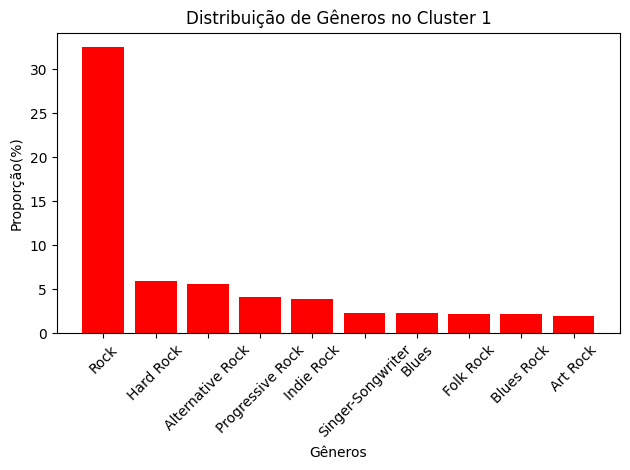

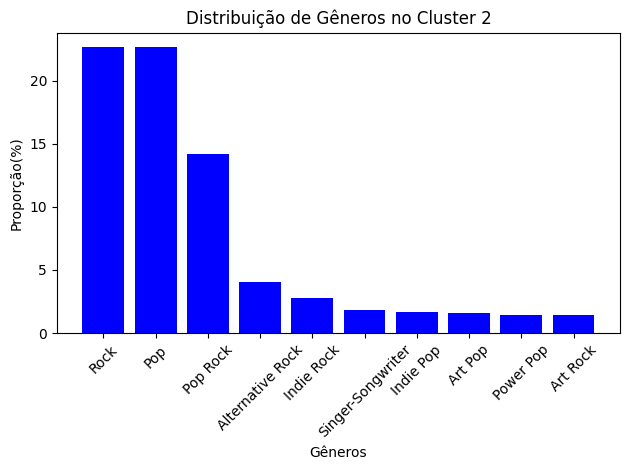

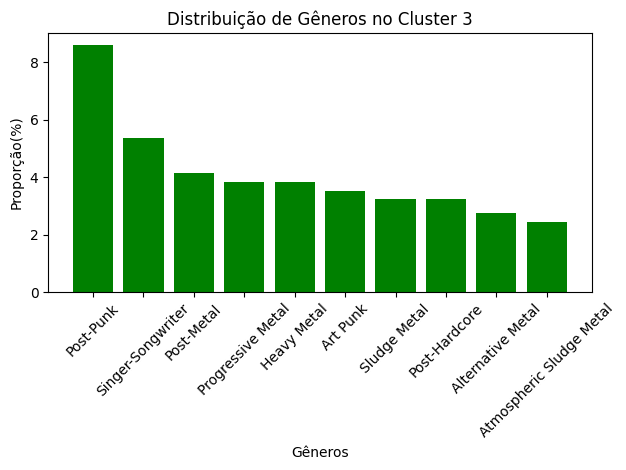

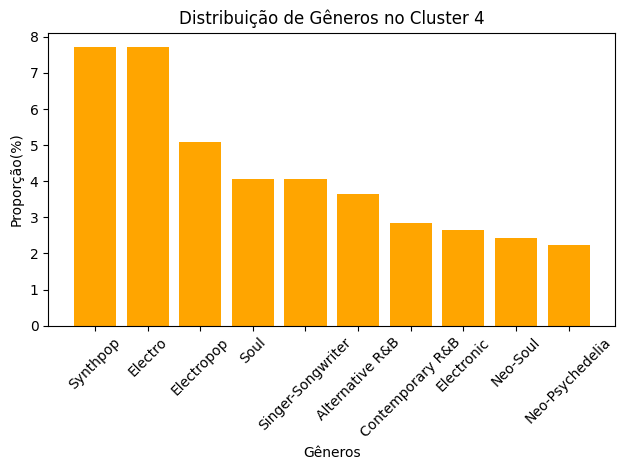

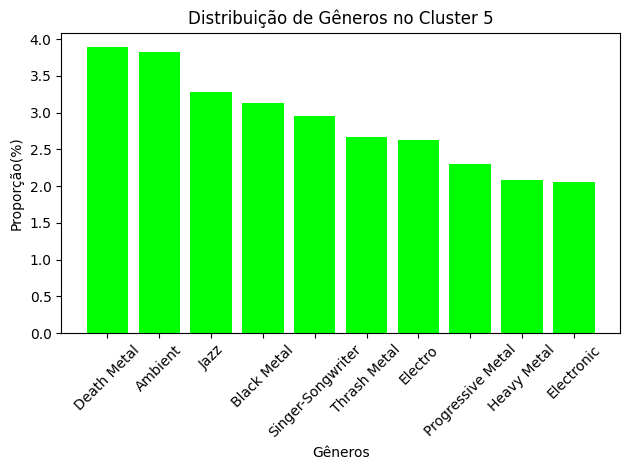

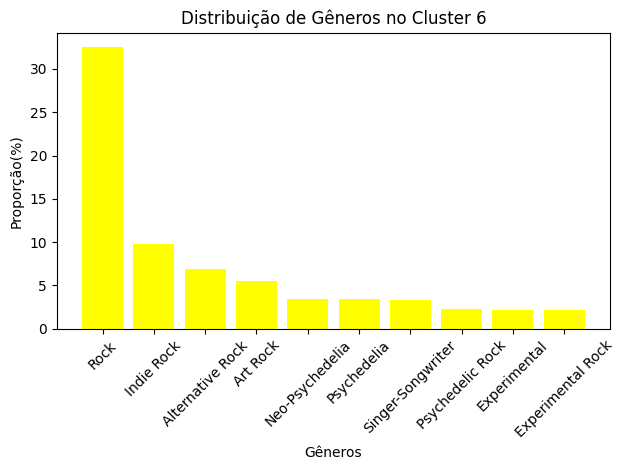

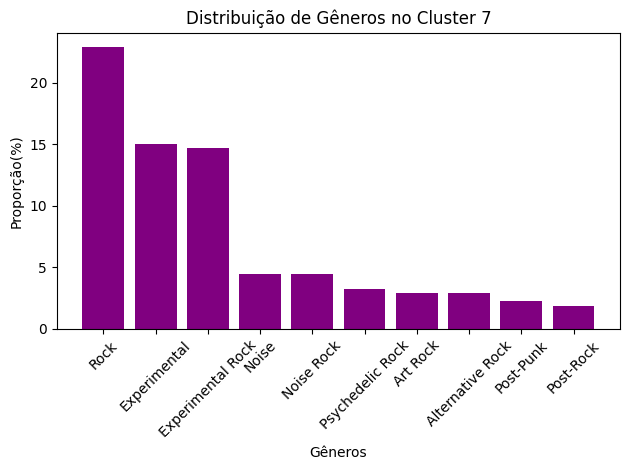

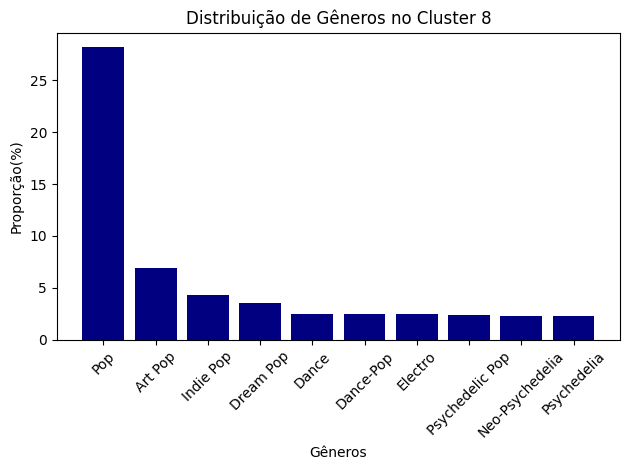

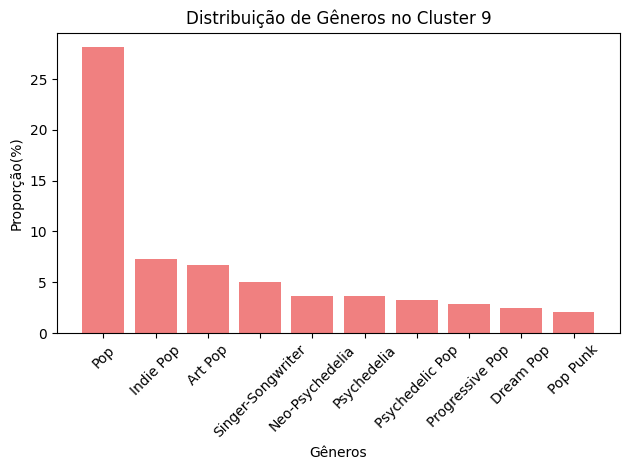

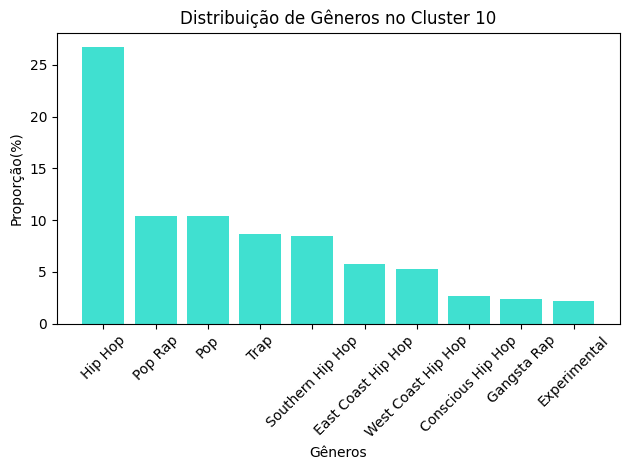

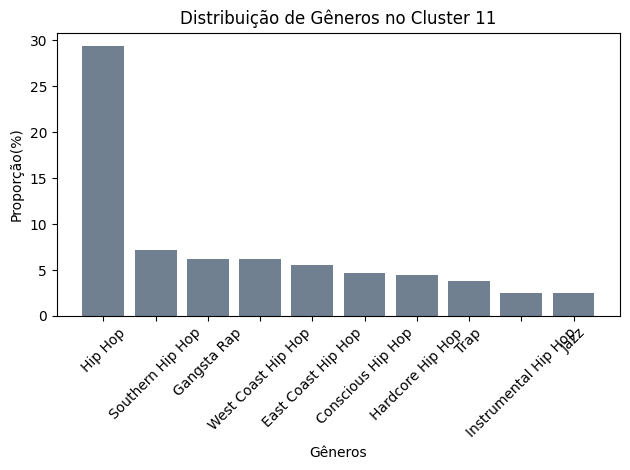

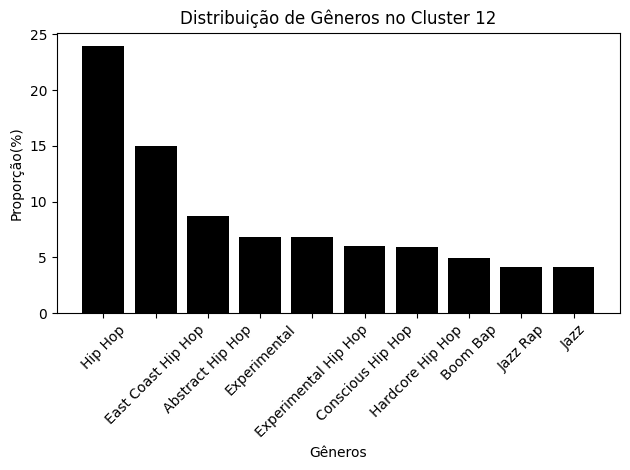

In [35]:
for i in range(num_clusters):
    proporcoes = generos_principais_por_cluster[i]
    plt.bar(proporcoes.keys(), proporcoes.values(), color=cores[i])

    plt.xlabel("Gêneros")
    plt.ylabel("Proporção(%)")
    plt.title(f"Distribuição de Gêneros no Cluster {i+1}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

##Conclusões
Ao analisarmos os clusters e comparamos seus gêneros predominantes, observamos uma relação interessante entre as dimensões e os gêneros musicais. O eixo x parece estar associado à predominância rock em um cluster, enquanto o eixo y reflete a quantidade de pop, e o eixo z está relacionado ao hip-hop. Além disso, percebemos não só que o eixo z representa o Hip Hop, mas também representa o quanto um cluster é 'experimental'. O quanto mais alto do eixo z, mais experimental um álbum tende a ser. Por exemplo, quando comparamos os clusters 1 e 7, o cluster 7 está acima do 1 e seus gêneros predominantes tendem a ser mais experimentais. Também podemos fazer essa comparação com os clusters 11 e 12. \
De certa forma, essa interpretação se alinha com a nossa modelagem inicial, onde álbuns mais à direita no eixo x tendem a ser mais relacionados ao rock, enquanto aqueles mais à frente no eixo y apresentam maior presença de pop. Clusters mais elevados no eixo z, por sua vez, indicam maior influência de hip-hop, além de indicar uma inclinação experimental.

In [36]:
C_reduzido

array([[ 4.54086473e+02,  1.26818414e+01,  1.20916809e-14],
       [-2.48191858e+02,  1.97879935e+02,  1.20916809e-14],
       [-2.05894615e+02, -2.10561776e+02,  1.20916809e-14]])

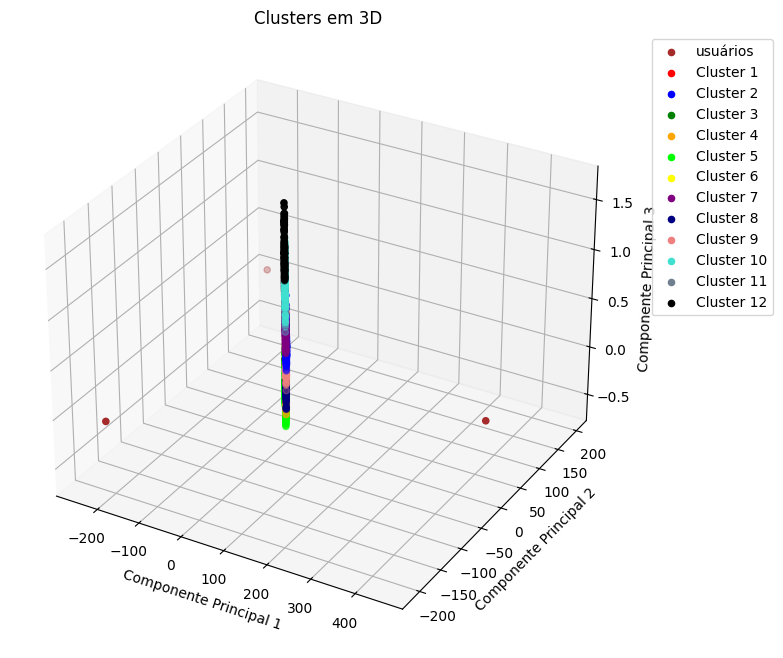

In [39]:
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(C_reduzido[:, 0], C_reduzido[:, 1], C_reduzido[:, 2], color='brown', label='usuários')
# for cluster_id, album in clusters3d.items():
#     color = plt.cm.rainbow(float(cluster_id) / clustering.n_clusters)
#     ax.scatter(album[:, 0], album[:, 1], album[:, 2], color=cores[cluster_id], label=f'Cluster {cluster_id+1}')

# ax.set_title('Clusters em 3D')
# ax.set_xlabel("Componente Principal 1")
# ax.set_ylabel("Componente Principal 2")
# ax.set_zlabel("Componente Principal 3")
# ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
# plt.show()

##TO DO
Comparar álbuns e usuários

#Fontes

Dataset: https://www.kaggle.com/datasets/tobennao/rym-top-5000 \
https://scikit-learn.org/1.5/modules/clustering.html#k-means \
https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans \
https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html